In [1]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

In [41]:
gamma_opt = 2*np.pi * 0.04    #frequencies in GHz
Delta_opt = 2*np.pi * 0
kappa_opt = 2*np.pi * 0.0

gamma_v = 2*np.pi * 10.
Delta_v = 2*np.pi * 2
n_th = 0
kappa_v = 2*np.pi * .0

Nvib = 50
sig = tensor( sigmam(), qeye(Nvib))
b = tensor(qeye(2), destroy(Nvib))

IDq = tensor(qeye(2), qeye(Nvib))

eta = 0.3
sig_p = sig * tensor(qeye(2), displace(Nvib, eta))

Gamma_plus = 0

delta_omega = 2*np.pi * 20


g = 2*np.pi * 20
g2S = 2*np.pi * 0
g2A = 2*np.pi * 0
gTHz = 2*np.pi * 0
g2DS = 2*np.pi * 0

H0 = Delta_v*b.dag()*b + Delta_opt*sig.dag()*sig + delta_omega * sig.dag()*sig*b.dag()*b
H_AS = g/2*( sig*b + sig.dag()*b.dag() )
H_S = g/2.*( sig*b.dag() + sig.dag()*b )
HR_2 = eta/2 * g2S/2.*( sig.dag()*b*b + sig*b.dag()*b.dag() )
HAR_2 = eta/2 * g2A/2.*( sig.dag()*b.dag()*b.dag() + sig*b*b )
HD_S = eta/2 * g2DS/2.*( sig.dag()*b*b + sig*b.dag()*b.dag() + (sig.dag()+sig)*b.dag()*b )

Hin = H0 + (H_S + H_AS) + (HR_2 + HAR_2) + gTHz/2.*(b+b.dag())
c_jumps = [ np.sqrt(gamma_v*(1 + n_th))*b, np.sqrt(gamma_v*(n_th))*b.dag(), np.sqrt(kappa_v)*b.dag()*b, np.sqrt(gamma_opt)*sig, np.sqrt(Gamma_plus)*sig.dag(), np.sqrt(kappa_opt)*sig.dag()*sig ]

evals, evecs = Hin.eigenstates(sort='low')


Parity = ( 1j*np.pi*(b.dag()*b + sig.dag()*sig) ).expm()
e_ops = []


c0_ran = np.random.rand(5)
psi0 = 1*evecs[0]
for nc0 in range(1,len(c0_ran)-1):
    psi0 += c0_ran[nc0]*evecs[nc0]              #initialize psi0 in a partially random state at low energy
psi0 = psi0/np.sqrt(np.abs(psi0.overlap(psi0))) #normalize it
psi0 = .5*(IDq - Parity)*psi0                   #project psi0 on a well defined parity sector (to go faster to steady state)
psi0 = psi0/np.sqrt(np.abs(psi0.overlap(psi0))) #normalize
print( np.abs(psi0.overlap(psi0)) )             #verify normalization

Ntimes = 5000
tlist = np.linspace(0, 100, Ntimes)  # in ns
Ntraj = 1

#options = Options(num_cpus=3, gui=False, atol=1e-10)
options = Options(atol=1e-9, norm_t_tol=1e-10, norm_tol=1e-6)

rho_ss = psi0 * psi0.dag() *0
for ntraj in range(Ntraj):
    sol = mcsolve(Hin, psi0, tlist, c_jumps, e_ops, ntraj=1, options=options)
    
    psi_t = sol.states
    psi_ss = psi_t[Ntimes-1]
    #if ntraj == 0:
    #    rho_ss = psi_ss * psi_ss.dag()/Ntraj
    #else:
    #    rho_ss += psi_ss * psi_ss.dag()/Ntraj
    rho_ss += psi_ss * psi_ss.dag()/Ntraj/2.

0.9999999999999999
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:  10.50s


In [42]:
avg_parity = expect(Parity, rho_ss)
avg_sx = expect(sig+sig.dag(), rho_ss)
print("parity = %.2f sx = %.2f\n" % ( avg_parity, avg_sx ))

parity = -0.50 sx = 0.00



In [43]:
xvec = np.linspace(-4, 4, 400)

W = wigner( (sig.dag()*sig*rho_ss*sig.dag()*sig).ptrace(1), xvec, xvec )
#W = wigner( (rho_ss).ptrace(1), xvec, xvec )

normW = (np.amax(W)-np.amin(W))/2

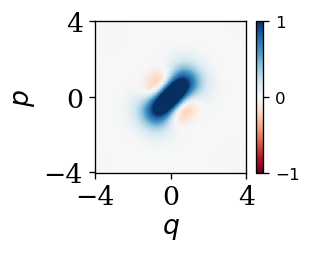

In [44]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt


font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Initialize figure for Wigner function animation
fig_w, ax_w = plt.subplots(dpi=120, figsize=(5, 5))
X, Y = np.meshgrid(xvec, xvec)

# Normalize the colormap around 0
custom_cmap = LinearSegmentedColormap.from_list('white_to_blue', [(1, 1, 1), (0, 0, 1)])  # White to Blue
norm = Normalize(vmin=-1.0, vmax=1.0)

# Create the pcolormesh plot
wigner_plot = ax_w.pcolormesh(X, Y, W / normW, cmap='RdBu', shading='auto', norm=norm)

# Add the color bar and set its ticks
cbar = fig_w.colorbar(wigner_plot, ax=ax_w, orientation='vertical', shrink=0.8)
cbar.set_ticks([-1, 0, 1])

# Set xticks, yticks, and labels
ax_w.set_xticks([-4, 0, 4])
ax_w.set_yticks([-4, 0, 4])
ax_w.set_xlabel(r'$q$', fontdict=font)
ax_w.set_ylabel(r'$p$', fontdict=font)
ax_w.set_aspect('equal')

# Customize tick labels
plt.xticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])
plt.yticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])

# Adjust layout
plt.gcf().set_size_inches(67 / 25.4, 60 / 25.4)
plt.tight_layout()

#plt.savefig('symmetric_traj_wigner_parity%.0f.png' % (avg_parity), dpi=300, transparent=True)
#plt.savefig('a-symmetric_traj_wigner_sx%.0f.png' % (avg_sx), dpi=300, transparent=True)

plt.show()

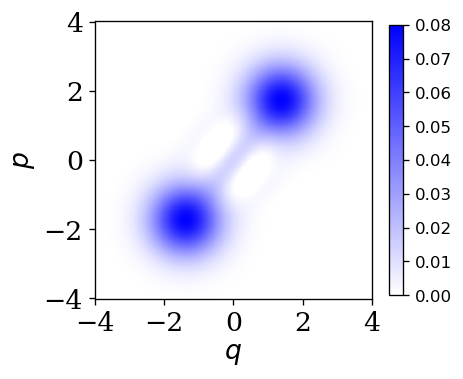

In [242]:
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from IPython.display import HTML

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

# Initialize figure for Wigner function animation
fig_w, ax_w = plt.subplots(dpi=120, figsize=(5, 5))
#xvec = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(xvec, xvec)


# Normalize the colormap around 0
#norm = Normalize(vmin=np.min(W.real)/10, vmax=np.max(W.real)/10 )
custom_cmap = LinearSegmentedColormap.from_list('white_to_blue', [(1, 1, 1), (0, 0, 1)])  # White to Blue
norm = Normalize(vmin=0, vmax=.08 )

# Create the pcolormesh plot
wigner_plot = ax_w.pcolormesh(X, Y, W, cmap=custom_cmap, shading='auto', norm=norm)

# Add the color bar
cbar = fig_w.colorbar(wigner_plot, ax=ax_w, orientation='vertical', shrink=0.8)
#cbar.set_label(r'Wigner Function $W(x, p)$', fontdict=font)

# Set labels and aspect ratio
ax_w.set_xlabel(r'$q$',fontdict=font)
ax_w.set_ylabel(r'$p$', fontdict=font)
ax_w.set_aspect('equal')

plt.xticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])
plt.yticks(fontsize=font['size'], fontname=font['family'], weight=font['weight'], color=font['color'])

#plt.grid()
plt.gcf().set_size_inches(100 / 25.4, 90 / 25.4)
plt.tight_layout()

#plt.savefig('wigner_parity.png', dpi=300)